# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Weather Conditions KMeans Clustering

--------------------


K-Means is an unsupervised machine learning algorithm used to group similar data into clusters. Clustering is the process of dividing a dataset into groups where elements within each group are more similar to each other than to elements in other groups. K-Means works by identifying K central points (centroids) and assigning each observation to the nearest centroid, iteratively adjusting the centroid positions until converging to a stable solution. In the climate context, this allows us to identify natural patterns in the data, such as "hot and humid days" or "cold and dry days," without manually defining these categories. This technique is especially useful for discovering hidden structures in large volumes of meteorological data.

| Cluster | Category Name | Characteristics |
|---------|---------------|-----------------|
| 0 | Cold and Dry | Low temperature and low humidity |
| 1 | Hot and Humid | High temperature and high humidity |
| 2 | Moderate | Moderate temperature and humidity |
| 3 | Cold and Humid | Low temperature and high humidity |

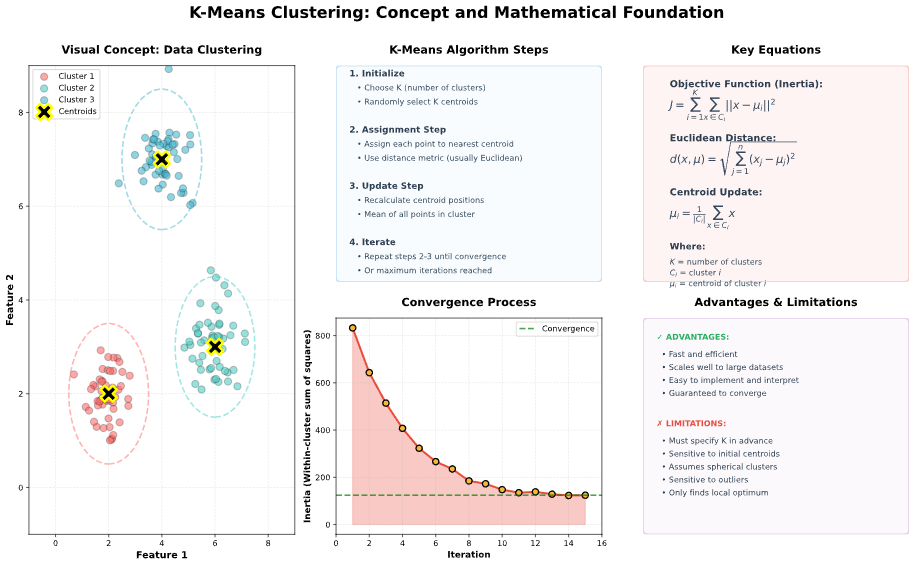

In [ ]:
# ============================================
# K-MEANS CLUSTERING - VERSÃO COMPACTA
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ============================================
# 1. CALCULAR MÉDIAS DOS SENSORES
# ============================================

temp_columns = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
                'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C']
humidity_columns = ['Umid_AHT20_pct', 'Umid_DHT11_pct']
pressure_columns = ['Press_BMP280_hPa', 'Press_BMP180_hPa']

df['Temp_Mean_C'] = df[temp_columns].mean(axis=1, skipna=True)
df['Humidity_Mean_pct'] = df[humidity_columns].mean(axis=1, skipna=True)
df['Pressure_Mean_hPa'] = df[pressure_columns].mean(axis=1, skipna=True)

# ============================================
# 2. PREPARAR DADOS
# ============================================

features_cols = ['Temp_Mean_C', 'Humidity_Mean_pct', 'Pressure_Mean_hPa']
df_features = df[features_cols].dropna()

print(f"📊 Amostras válidas: {len(df_features):,}")
print(f"\n📈 Estatísticas:")
print(df_features.describe().round(2))

# ============================================
# 3. NORMALIZAR
# ============================================

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

# ============================================
# 4. DETERMINAR K ÓTIMO
# ============================================

K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(features_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans_temp.labels_))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0].set_xlabel('K', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#3498DB')
axes[1].set_xlabel('K', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 5. APLICAR K-MEANS
# ============================================

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
clusters = kmeans.fit_predict(features_scaled)

df.loc[df_features.index, 'cluster'] = clusters

print(f"\n✓ K-Means com {n_clusters} clusters")
print(f"\n📊 Distribuição:")
print(df['cluster'].value_counts().sort_index())

# ============================================
# 6. ANALISAR CLUSTERS
# ============================================

centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original, columns=features_cols)

print(f"\n🎯 Centróides:")
print(centroids_df.round(2))

# ============================================
# 7. VISUALIZAR
# ============================================

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_features['Temp_Mean_C'],
                     df_features['Humidity_Mean_pct'],
                     c=clusters,
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.scatter(centroids_original[:, 0],
           centroids_original[:, 1],
           c='red',
           s=400,
           marker='X',
           edgecolors='black',
           linewidth=2,
           label='Centroids',
           zorder=5)

plt.xlabel('Temperature (°C)', fontsize=13, fontweight='bold')
plt.ylabel('Humidity (%)', fontsize=13, fontweight='bold')
plt.title('Climate Clustering - K-Means', fontsize=15, fontweight='bold')
plt.colorbar(scatter, label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 8. MÉTRICAS
# ============================================

silhouette_avg = silhouette_score(features_scaled, clusters)
davies_bouldin = davies_bouldin_score(features_scaled, clusters)

print(f"\n📊 MÉTRICAS:")
print(f"  • Silhouette Score: {silhouette_avg:.4f}")
print(f"  • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  • Inertia: {kmeans.inertia_:.2f}")

# ============================================
# 9. SALVAR
# ============================================

df[['Timestamp', 'Temp_Mean_C', 'Humidity_Mean_pct',
    'Pressure_Mean_hPa', 'cluster']].to_csv('climate_clusters.csv', index=False)

print(f"\n✓ Salvo: climate_clusters.csv")

📊 Amostras válidas: 82,430

📈 Estatísticas:
       Temp_Mean_C  Humidity_Mean_pct  Pressure_Mean_hPa
count     82430.00           82430.00           82430.00
mean         21.17              61.39             919.09
std           3.46              13.47               2.01
min          14.19              27.35             913.30
25%          18.50              50.28             917.62
50%          20.61              63.98             919.24
75%          23.85              72.88             920.63
max          30.35              87.90             923.59
